# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to work in pairs. 

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. `hwutils.py`) so they can be commented on easily and focus the notebook on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [1]:
# useful libraries to import
import sys

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)
import seaborn as sns;sns.set()

from hwutils import *

In [2]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/fr/0b8hv04x6_lct76cwxs_zbw80000gn/T/ipykernel_2843/1708817607.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')


**1. After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?**


Text(0.5, 1.0, 'ENCFF520IHF')

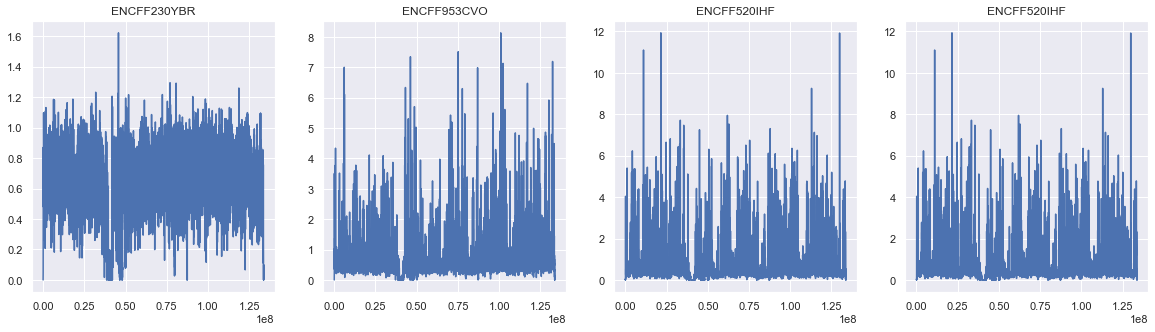

In [3]:
# Suggest to use line plot for better readability.
# Also to use subplots() to make the entire code more simple.
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax[0].plot(df.start, df.ENCFF230YBR)
ax[0].set_title("ENCFF230YBR")
ax[1].plot(df.start, df.ENCFF953CVO)
ax[1].set_title("ENCFF953CVO")
ax[2].plot(df.start, df.ENCFF520IHF)
ax[2].set_title("ENCFF520IHF")
ax[3].plot(df.start, df.ENCFF520IHF)
ax[3].set_title("ENCFF520IHF")


#### Q1 Answer: 
In each of these plots we can see a dip at around 40Mb. This could be an indicator that the centromer is located at approximately 40Mb. After looking this up (https://en.wikipedia.org/wiki/Chromosome_10), we see that the centromere's position in chromosome 10 is indeed at 39.8 Mb, explaining the dip in signal.

**2. Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.**


In [4]:
# Using the method from class
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x=df.iloc[:,3:]
pca.fit(x)

PCA(n_components=2)

Text(0, 0.5, 'component 2')

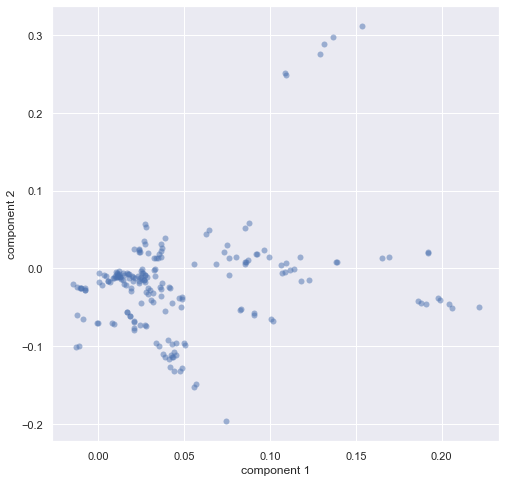

In [5]:
# Using hwutils
plot_pca(pca)
plt.xlabel('component 1')
plt.ylabel('component 2')

**3. Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.**

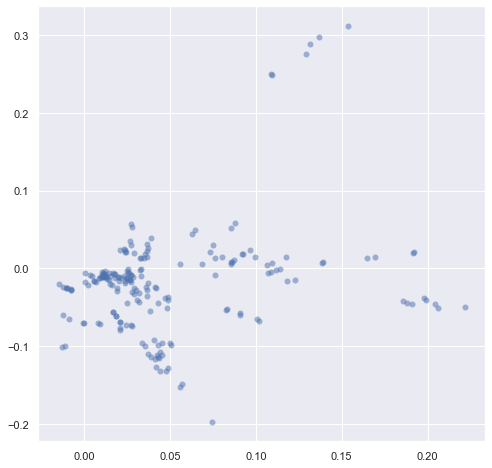

In [6]:
plot_pca(pca,bigwig_metadata=bigwig_metadata)

In [41]:
# Column names for reference
bigwig_metadata.columns

Index(['Unnamed: 0', 'File accession', 'File format', 'File type',
       'File format type', 'Output type', 'File assembly',
       'Experiment accession', 'Assay', 'Donor(s)', 'Biosample term id',
       'Biosample term name', 'Biosample type', 'Biosample organism',
       'Biosample treatments', 'Biosample treatments amount',
       'Biosample treatments duration',
       'Biosample genetic modifications methods',
       'Biosample genetic modifications categories',
       'Biosample genetic modifications targets',
       'Biosample genetic modifications gene targets',
       'Biosample genetic modifications site coordinates',
       'Biosample genetic modifications zygosity', 'Experiment target',
       'Library made from', 'Library depleted in', 'Library extraction method',
       'Library lysis method', 'Library crosslinking method',
       'Library strand specific', 'Experiment date released', 'Project',
       'RBNS protein concentration', 'Library fragmentation method',
      

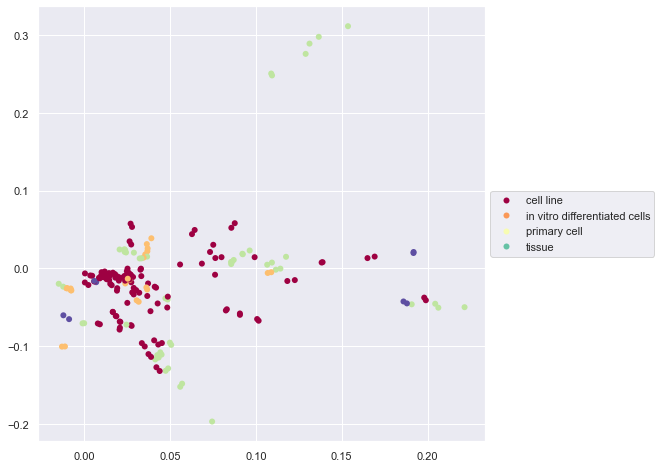

In [7]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biosample type",alpha=1)

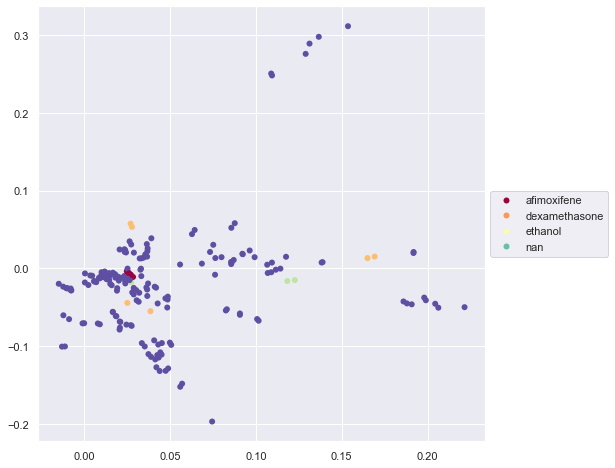

In [8]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biosample treatments",alpha=1)

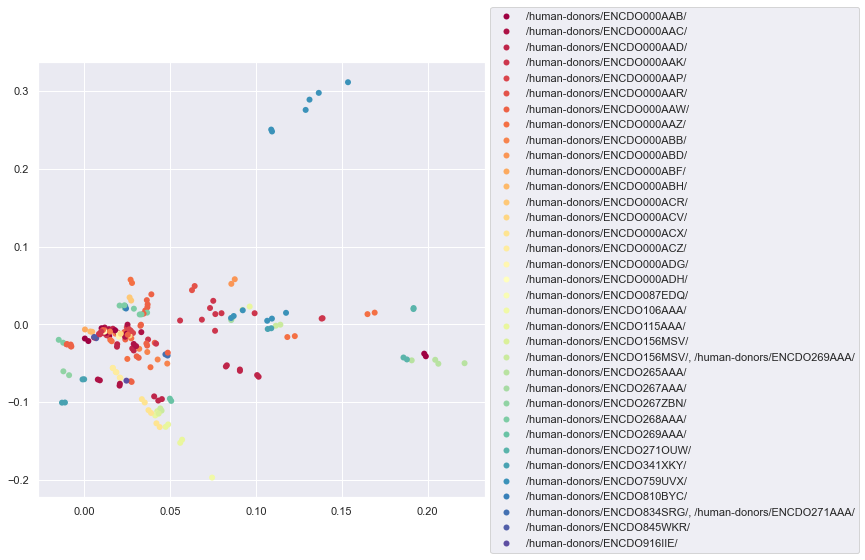

In [9]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Donor(s)",alpha=1)

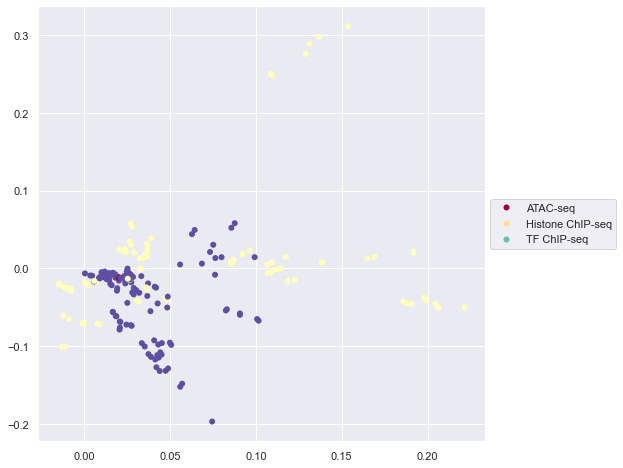

In [10]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Assay",alpha=1)

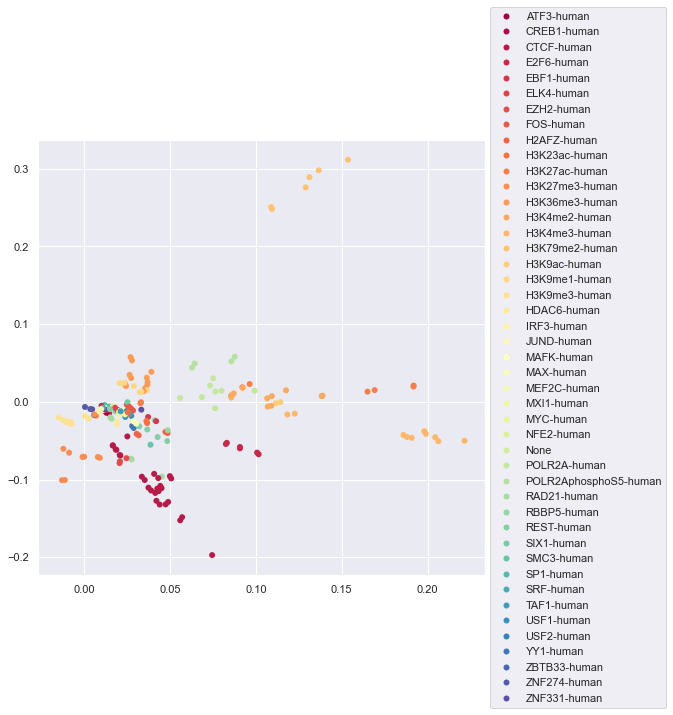

In [11]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Experiment target",alpha=1)

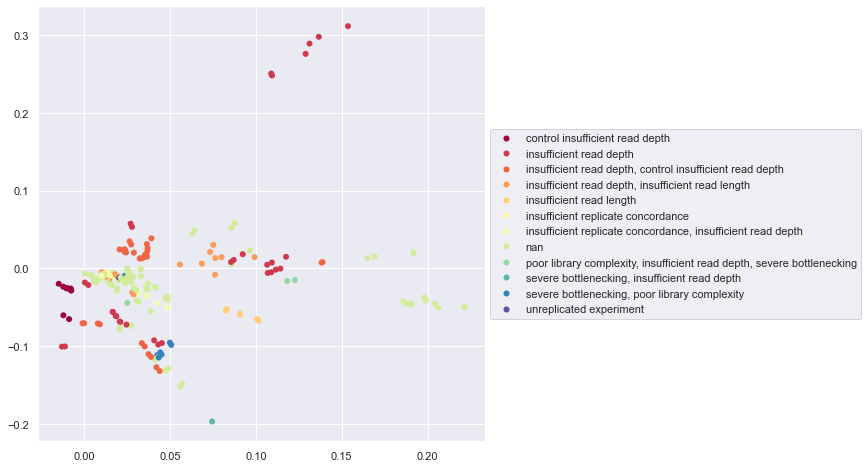

In [12]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Audit NOT_COMPLIANT",alpha=1)

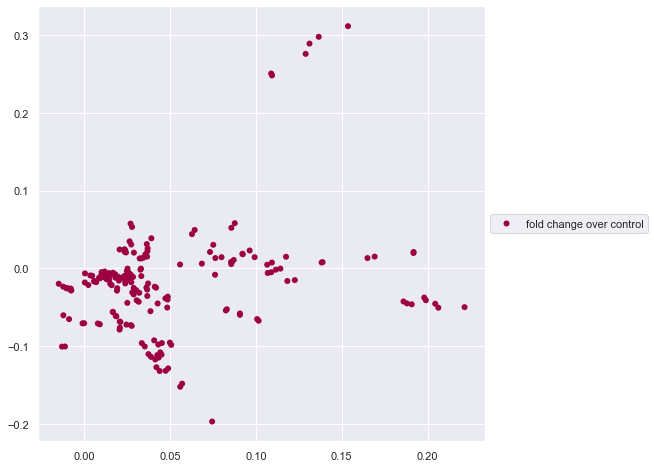

In [13]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Output type",alpha=1)

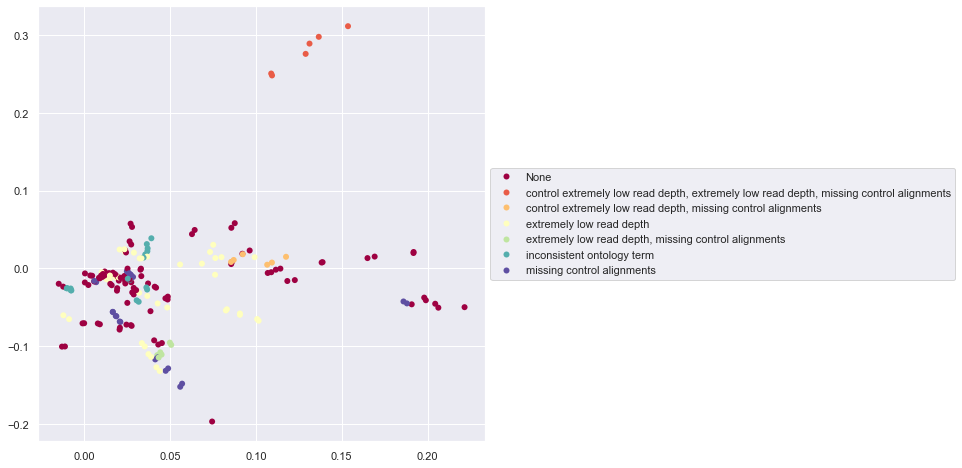

In [14]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Audit ERROR",alpha=1)

#### Q3 Answer:
Based on the plots above, we find that "Audit ERROR" is a good column to use for outlier removal. We consider the outliers to be the group at the very top of the plot.

We can remove outliers by dropping all the experiments where "Audit ERROR" = "control extremely low read depth, extremely low read depth, missing control alignments"

This is done below.

In [15]:
# Filter out items in metadata that are not in df
filtered_bigwig_metadata=bigwig_metadata[bigwig_metadata["File accession"].isin(df.columns[3:])]
#filtered_bigwig_metadata

In [16]:
# What are our outliers based on "Audit ERROR" column
outliers_df = filtered_bigwig_metadata.loc[filtered_bigwig_metadata["Audit ERROR"] == "control extremely low read depth, extremely low read depth, missing control alignments"]
outlier_accessions = outliers_df["File accession"].values.tolist()

# How many outliers?
len(outlier_accessions)

6

In [17]:
# Length of df
len(df.columns)

203

In [18]:
# Filter df by outliers
filtered_df = df.drop(outlier_accessions, axis=1)

# Length of filtered df
# We expect this to be 197 (203-6)
len(filtered_df.columns)

197

In [19]:
# Length of filtered metadata before outlier removal
len(filtered_bigwig_metadata)

200

In [20]:
# Remove outliers based on "Audit ERROR column"
filtered_bigwig_metadata = filtered_bigwig_metadata.drop(filtered_bigwig_metadata.index[filtered_bigwig_metadata["Audit ERROR"] ==  'control extremely low read depth, extremely low read depth, missing control alignments'])

# Length of filtered metadata after outlier removal
# We expect this to be 194 (200-6)
len(filtered_bigwig_metadata)

194

In [21]:
# Look at our updated plot
pca_outlier_removal = PCA(n_components=2)
x=filtered_df.iloc[:,3:]
pca_outlier_removal.fit(x)

PCA(n_components=2)

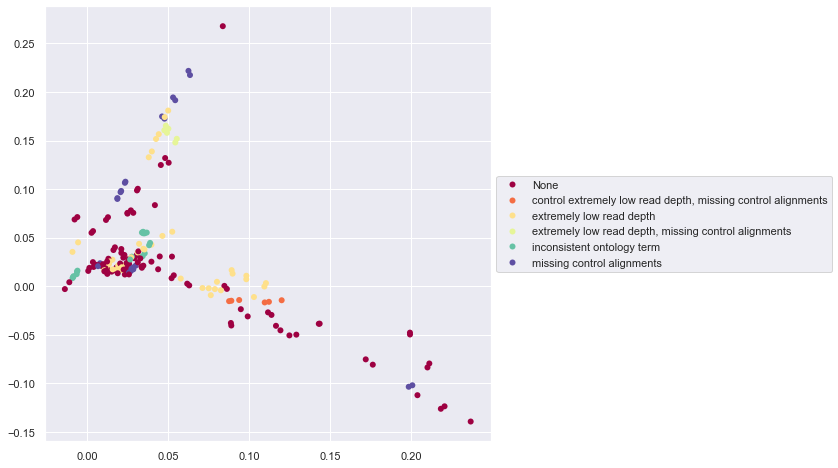

In [22]:
plot_pca(pca_outlier_removal,bigwig_metadata=filtered_bigwig_metadata,metadata_label_column="Audit ERROR",alpha=1)

We can see that the plot has changed after removing the outliers based on "Audit Error". We can also see that we sucessfully removed the outliers, because the label doesn't show up in the legend. 

**4. Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.**


In [26]:
# We'll use assays for this question
# How many assays do we have?
filtered_bigwig_metadata["Assay"].unique()

array(['TF ChIP-seq', 'Histone ChIP-seq', 'ATAC-seq'], dtype=object)

In [35]:
#filtered_df

## TF ChIP-seq

In [36]:
# Get chip-seq experiments
tfchipseq=filtered_bigwig_metadata.loc[(filtered_bigwig_metadata["Assay"]=="TF ChIP-seq")]
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_rows', 500)
#tfchipseq[['File accession','Biosample term name']]

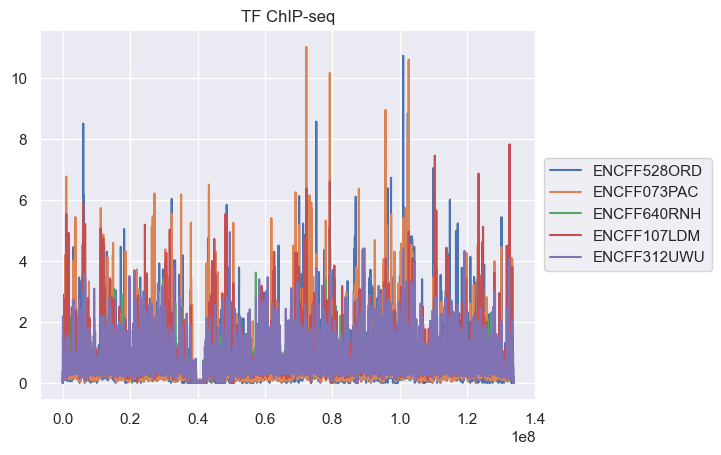

In [37]:
plt.plot(filtered_df.start, filtered_df.ENCFF528ORD,label = "ENCFF528ORD") 
plt.plot(filtered_df.start, filtered_df.ENCFF073PAC,label = "ENCFF073PAC") 
plt.plot(filtered_df.start, filtered_df.ENCFF640RNH,label = "ENCFF640RNH")
plt.plot(filtered_df.start, filtered_df.ENCFF107LDM,label = "ENCFF107LDM") 
plt.plot(filtered_df.start, filtered_df.ENCFF312UWU,label = "ENCFF312UWU") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("TF ChIP-seq")
plt.show()

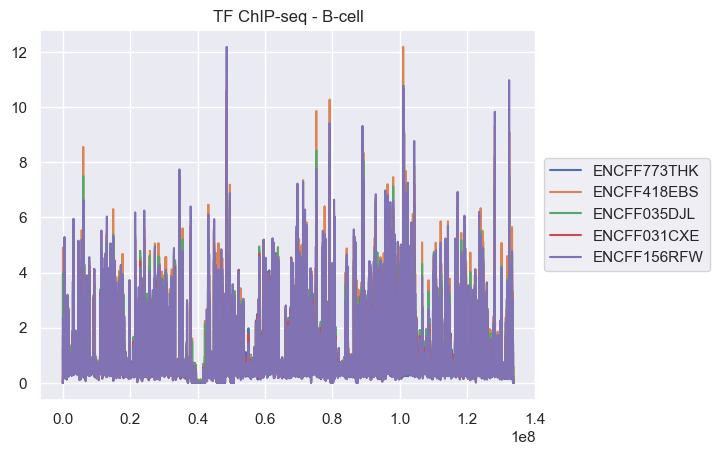

In [38]:
plt.plot(filtered_df.start, filtered_df.ENCFF773THK, label = "ENCFF773THK") 
plt.plot(filtered_df.start, filtered_df.ENCFF418EBS, label = "ENCFF418EBS") 
plt.plot(filtered_df.start, filtered_df.ENCFF035DJL, label = "ENCFF035DJL")
plt.plot(filtered_df.start, filtered_df.ENCFF031CXE, label = "ENCFF031CXE") 
plt.plot(filtered_df.start, filtered_df.ENCFF156RFW, label = "ENCFF156RFW") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("TF ChIP-seq - B-cell")
plt.show()

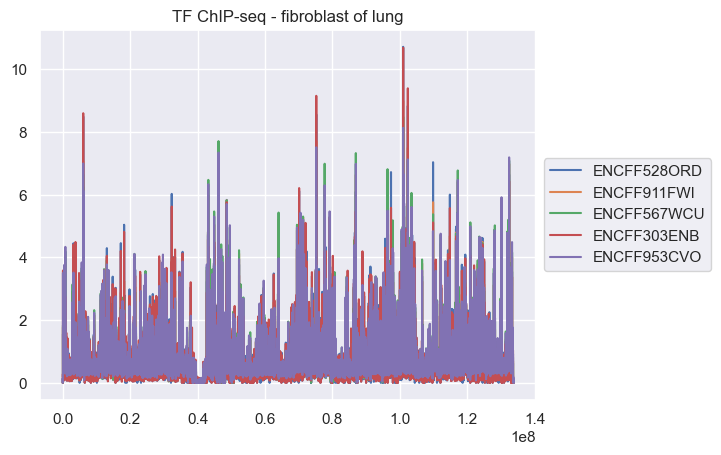

In [39]:
plt.plot(filtered_df.start, filtered_df.ENCFF528ORD, label = "ENCFF528ORD") 
plt.plot(filtered_df.start, filtered_df.ENCFF911FWI, label = "ENCFF911FWI") 
plt.plot(filtered_df.start, filtered_df.ENCFF567WCU, label = "ENCFF567WCU")
plt.plot(filtered_df.start, filtered_df.ENCFF303ENB, label = "ENCFF303ENB") 
plt.plot(filtered_df.start, filtered_df.ENCFF953CVO, label = "ENCFF953CVO") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("TF ChIP-seq - fibroblast of lung")
plt.show()

## Histone ChIP-seq

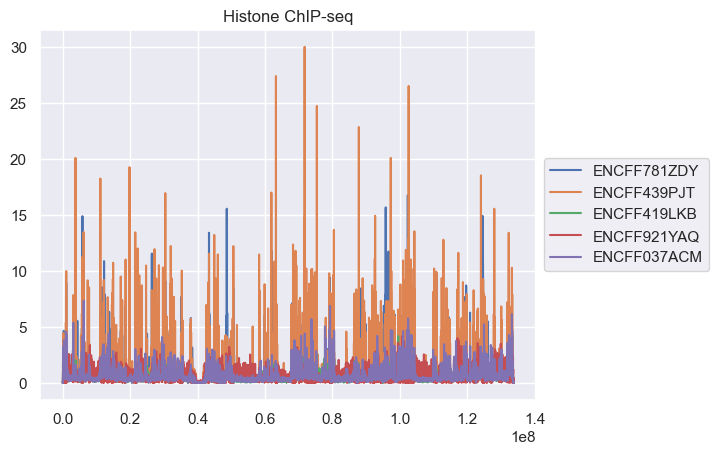

In [40]:
plt.plot(filtered_df.start, filtered_df.ENCFF781ZDY, label = "ENCFF781ZDY") 
plt.plot(filtered_df.start, filtered_df.ENCFF439PJT, label = "ENCFF439PJT") 
plt.plot(filtered_df.start, filtered_df.ENCFF419LKB, label = "ENCFF419LKB")
plt.plot(filtered_df.start, filtered_df.ENCFF921YAQ, label = "ENCFF921YAQ") 
plt.plot(filtered_df.start, filtered_df.ENCFF037ACM,label = "ENCFF037ACM") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Histone ChIP-seq")
plt.show()

In [41]:
#Get histone chip-seq experiments
histonechipseq = filtered_bigwig_metadata[filtered_bigwig_metadata['Assay'] == 'Histone ChIP-seq']
#histonechipseq[['File accession','Biosample term name']]

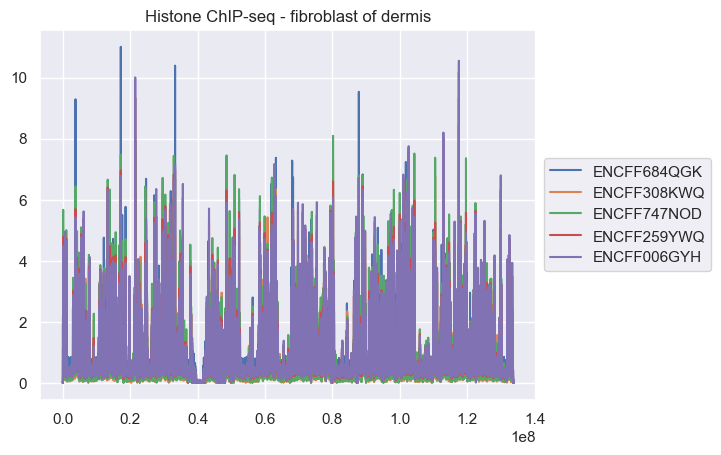

In [42]:
plt.plot(filtered_df.start, filtered_df.ENCFF684QGK, label = "ENCFF684QGK") 
plt.plot(filtered_df.start, filtered_df.ENCFF308KWQ, label = "ENCFF308KWQ") 
plt.plot(filtered_df.start, filtered_df.ENCFF747NOD, label = "ENCFF747NOD")
plt.plot(filtered_df.start, filtered_df.ENCFF259YWQ, label = "ENCFF259YWQ") 
plt.plot(filtered_df.start, filtered_df.ENCFF006GYH, label = "ENCFF006GYH") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Histone ChIP-seq - fibroblast of dermis")
plt.show()

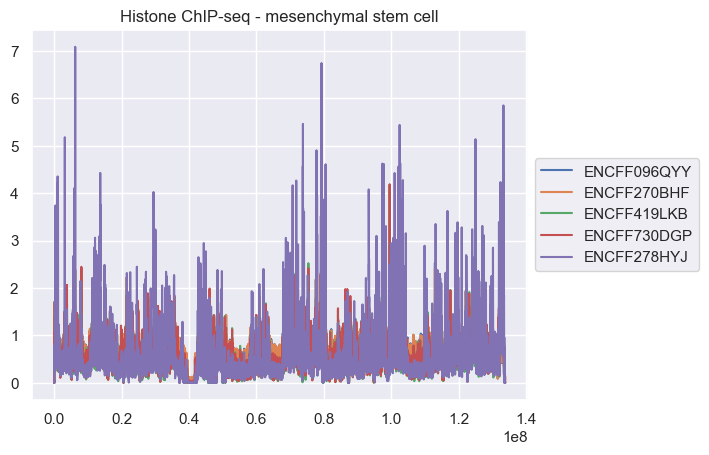

In [43]:
plt.plot(filtered_df.start, filtered_df.ENCFF096QYY, label = "ENCFF096QYY") 
plt.plot(filtered_df.start, filtered_df.ENCFF270BHF, label = "ENCFF270BHF") 
plt.plot(filtered_df.start, filtered_df.ENCFF419LKB, label = "ENCFF419LKB")
plt.plot(filtered_df.start, filtered_df.ENCFF730DGP, label = "ENCFF730DGP") 
plt.plot(filtered_df.start, filtered_df.ENCFF278HYJ, label = "ENCFF278HYJ") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Histone ChIP-seq - mesenchymal stem cell")
plt.show()

In [44]:
#Get atac-seq experiments
atacseq = filtered_bigwig_metadata[filtered_bigwig_metadata['Assay'] == 'ATAC-seq']
atacseq['File accession'].tolist()

['ENCFF890LTR']

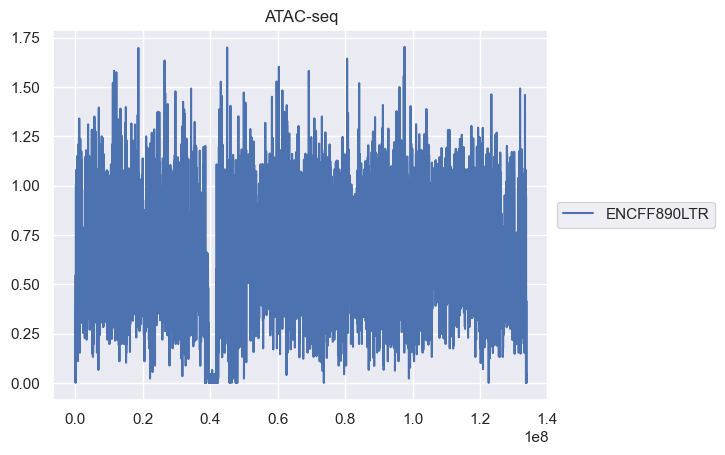

In [45]:
plt.plot(filtered_df.start, filtered_df.ENCFF890LTR,label = "ENCFF890LTR") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("ATAC-seq")
plt.show()

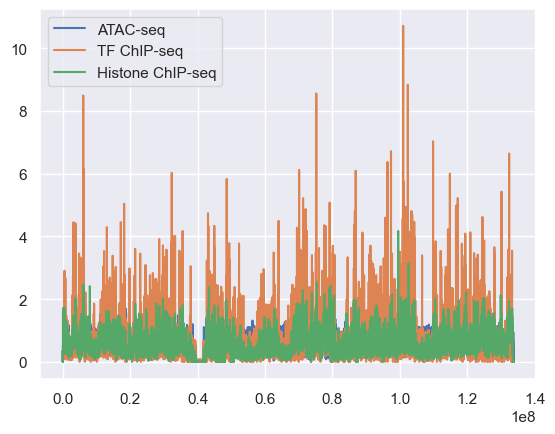

In [46]:
plt.plot(filtered_df.start, filtered_df.ENCFF890LTR,label = "ATAC-seq") 
plt.plot(filtered_df.start, filtered_df.ENCFF528ORD,label = "TF ChIP-seq") 
plt.plot(filtered_df.start, filtered_df.ENCFF419LKB,label = "Histone ChIP-seq")
plt.legend()
plt.show()

In [47]:
# Compute Autocorrelation:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [48]:
def autocorr_name(experiment, assay, color, axes=None):
    x = filtered_df[experiment].tolist()
    z = autocorr(x)

    # Evolution of the name.
    axes[0].plot(filtered_df.start, x, '-o' + color,
                 label=experiment)
    axes[0].set_title("experiment1")
    axes[0].legend()

    # Autocorrelation.
    axes[1].plot(z / float(z.max()),
                 '-' + color, label=experiment)
    axes[1].legend()
    axes[1].set_title(assay)

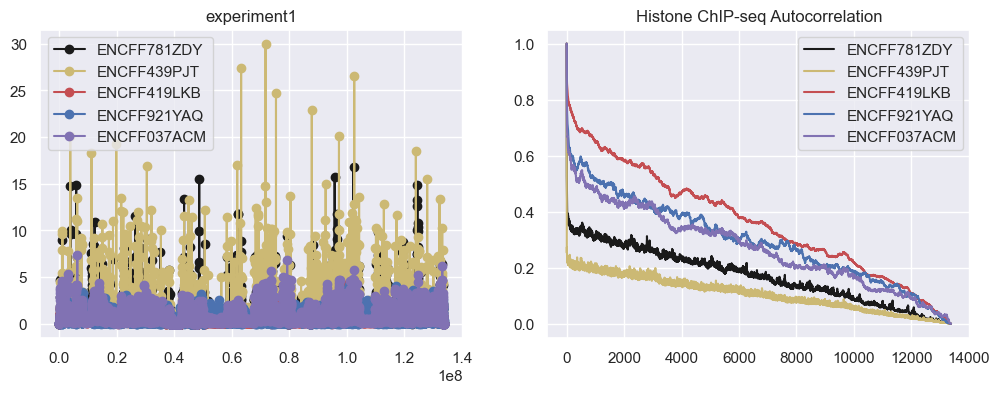

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
autocorr_name('ENCFF781ZDY', 'Histone ChIP-seq Autocorrelation', 'k', axes=axes)
autocorr_name('ENCFF439PJT', 'Histone ChIP-seq Autocorrelation', 'y', axes=axes)
autocorr_name('ENCFF419LKB', 'Histone ChIP-seq Autocorrelation', 'r', axes=axes)
autocorr_name('ENCFF921YAQ', 'Histone ChIP-seq Autocorrelation', 'b', axes=axes)
autocorr_name('ENCFF037ACM', 'Histone ChIP-seq Autocorrelation', 'm', axes=axes)

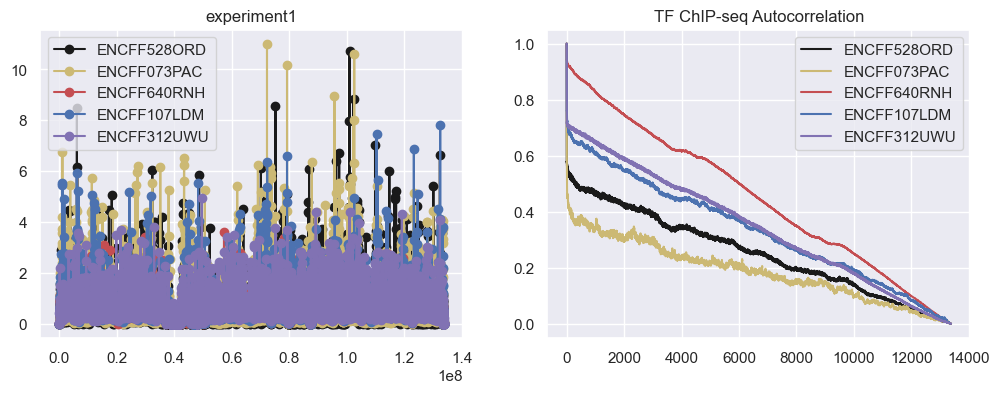

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
autocorr_name('ENCFF528ORD', 'TF ChIP-seq Autocorrelation', 'k', axes=axes)
autocorr_name('ENCFF073PAC', 'TF ChIP-seq Autocorrelation', 'y', axes=axes)
autocorr_name('ENCFF640RNH', 'TF ChIP-seq Autocorrelation', 'r', axes=axes)
autocorr_name('ENCFF107LDM', 'TF ChIP-seq Autocorrelation', 'b', axes=axes)
autocorr_name('ENCFF312UWU', 'TF ChIP-seq Autocorrelation', 'm', axes=axes)

#### Q4 Answer:
**Which Assays or Experiment Targets show broad vs narrow patterns?**
Looking at the different Assays we can see that Histone ChIP-seq has broader patterns than TF ChIP-seq. We only have one sample for ATAC-seq so we cannot say anything about that assay.

**Is this consistent across cell types?**
When we looked at differnet cell types within assays we observed that the patterns were very similar for both Histone ChIP-seq and TF ChIP-seq, so it seems to be consistent across cell types.

**Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.**
If we look at the PCA labeled by Assay the Histone ChIP-seq is not as concentrated in one place which makes sense looking at the broader pattern it displays in the plots. We see these same patterns in the autocorrelation plot, as we see broader patterns in the Histone ChIP-seq and smoother and more narrow lines for the TF ChIP-seq. 

**5. Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.**


In [28]:
#Adding a new column that combines experiment targets and cell type in the filtered_bigwig_metadata
filtered_bigwig_metadata["cell_type_target"] = filtered_bigwig_metadata["Biosample term name"].astype(str) +"-"+ filtered_bigwig_metadata["Experiment target"]

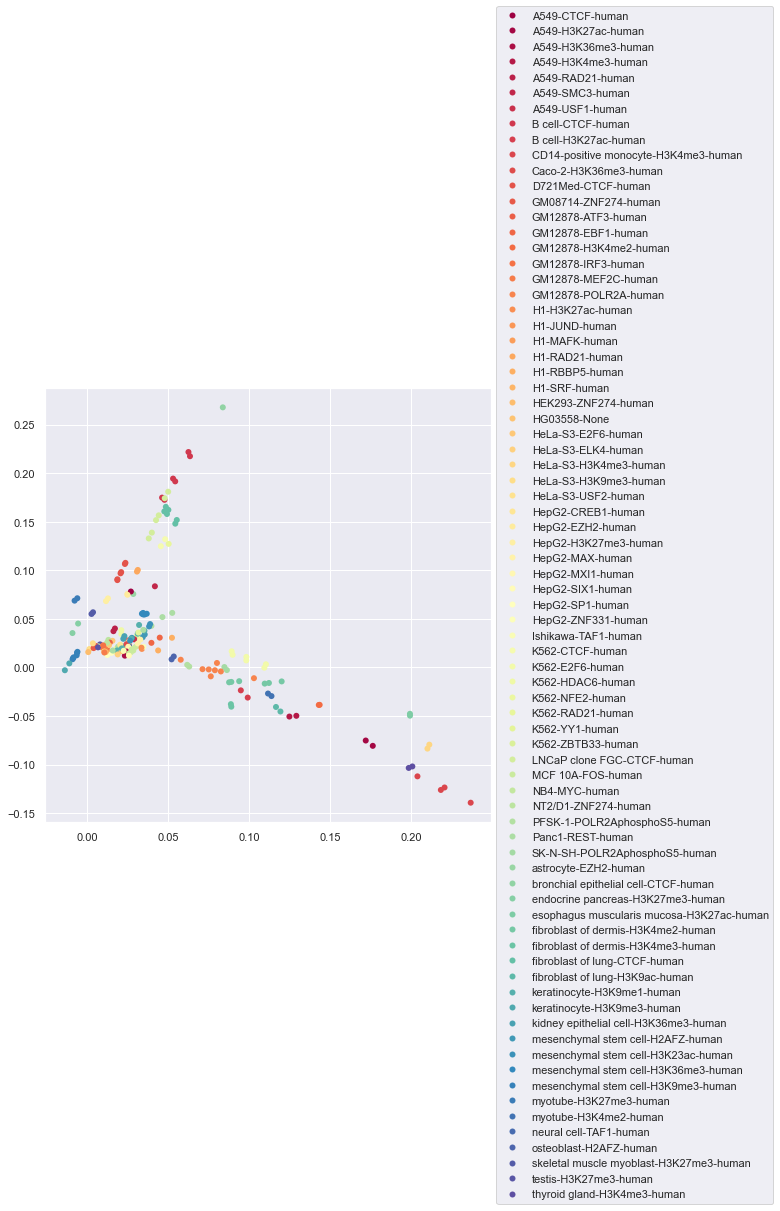

In [29]:
plot_pca(pca_outlier_removal,bigwig_metadata=filtered_bigwig_metadata,metadata_label_column="cell_type_target",alpha=1)

#### Q5 Answer:
In the bottom PCA we can see each point colored by experiment target for the differen cell types. Because of the many lables its hard to find a pattern in the PCA.

Since we found no pattern for the experiment targets, we cannot make any conclusions about polycomb-related factors or make other biological interpretations. 

**6. How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing.**


Which exact position in df is on centromer?

Text(0, 0.5, 'ENCFF230YBR')

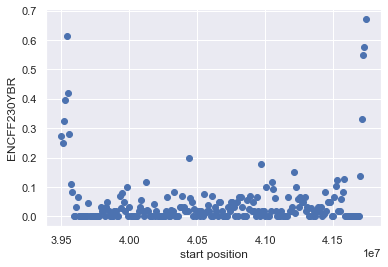

In [30]:
plt.scatter(filtered_df.iloc[3950:4175,:].start, filtered_df.iloc[3950:4175,:].ENCFF230YBR) 
plt.xlabel('start position')
plt.ylabel('ENCFF230YBR')

#dip at around 0.95-4.15

In [31]:
#remove area
filtered_df_no_dip=filtered_df.drop(list(range(3950, 4175)))

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(filtered_df_no_dip.iloc[:,3:])

StandardScaler()

In [33]:
scale_x=scaler.transform(filtered_df_no_dip.iloc[:,3:])

In [34]:
scale_projected = scaler.fit_transform(filtered_df_no_dip.iloc[:,3:])
print(scale_projected.shape)

(13155, 194)


In [35]:
from pandas import DataFrame
normalized_df=DataFrame(scale_projected)

In [36]:
filtered_df_no_dip.shape

(13155, 197)

In [37]:
normalized_df.columns = filtered_df_no_dip.iloc[:,3:].columns

In [38]:
normalized_df["start"]=filtered_df_no_dip.start
normalized_df["end"]=filtered_df_no_dip.end

Text(0, 0.5, 'ENCFF230YBR')

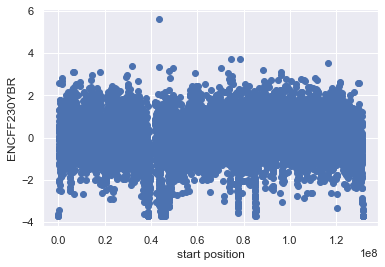

In [39]:
plt.scatter(normalized_df.start, normalized_df.ENCFF230YBR) 
plt.xlabel('start position')
plt.ylabel('ENCFF230YBR')

/var/folders/fr/0b8hv04x6_lct76cwxs_zbw80000gn/T/ipykernel_2843/3228045914.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


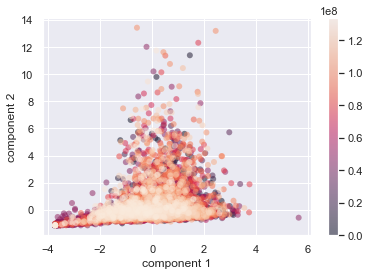

In [40]:
plt.scatter(scale_projected[:, 0], scale_projected[:, 1],
            c=filtered_df_no_dip.start, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [41]:
pca_normalized = PCA(n_components=2)
pca_normalized.fit(normalized_df.iloc[:,:194])

PCA(n_components=2)

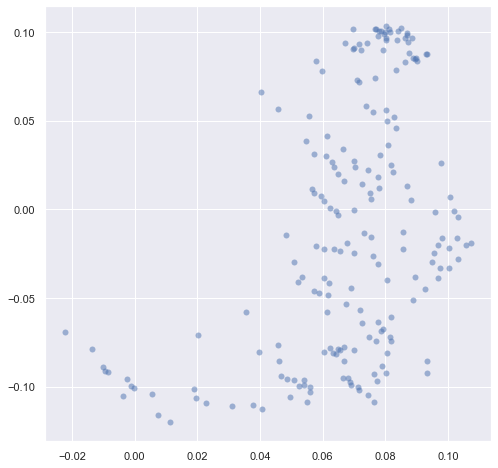

In [42]:
plot_pca(pca_normalized)

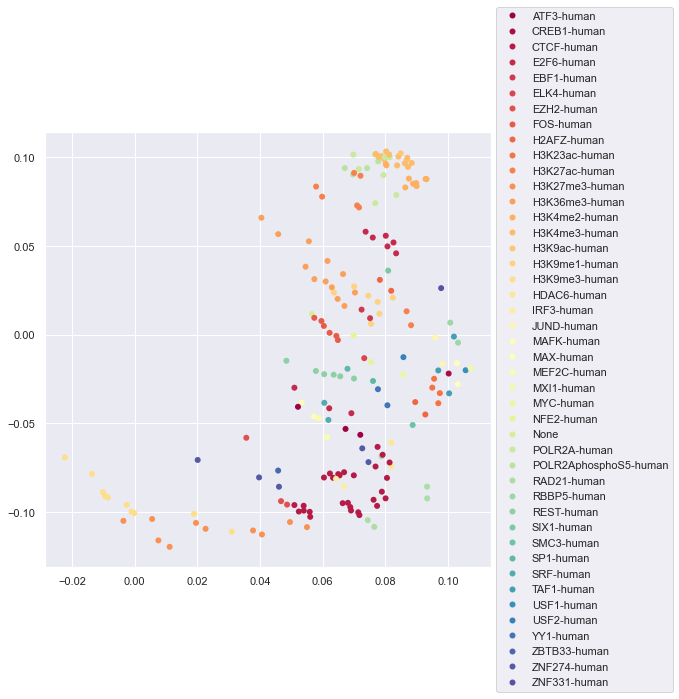

In [43]:
plot_pca(pca_normalized,bigwig_metadata=filtered_bigwig_metadata,metadata_label_column="Experiment target",alpha=1)

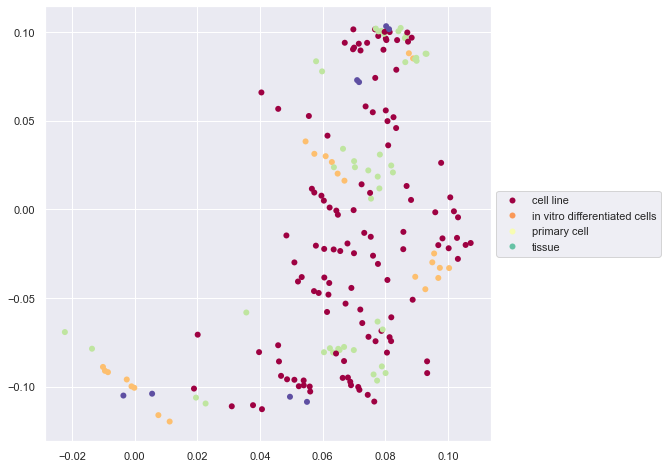

In [44]:
plot_pca(pca_normalized,bigwig_metadata=filtered_bigwig_metadata,metadata_label_column="Biosample type",alpha=1)

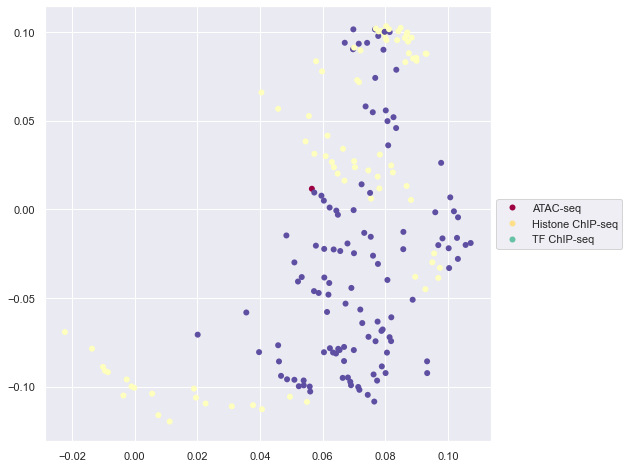

In [45]:
plot_pca(pca_normalized,bigwig_metadata=filtered_bigwig_metadata,metadata_label_column="Assay",alpha=1)

#### Q6 Answer:
Normalization seems to improve the clustering a bit. It did not change anything about our previous conclusions.


**7. How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot).**

In [46]:
from sklearn.decomposition import PCA
pca_var = PCA()
x=filtered_df_no_dip.iloc[:,3:]
x_pca = pca_var.fit_transform(x)

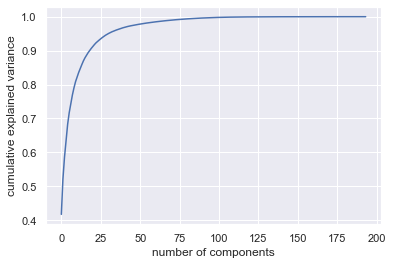

In [47]:
# Method from class
plt.plot(np.cumsum(pca_var.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [48]:
## Check which index+1 contains value closest to 90%
df1 = pd.DataFrame(np.cumsum(pca_var.explained_variance_ratio_))
df1.iloc[18]
# 19 PC's needed to explain 90%

0    0.90057
Name: 18, dtype: float64

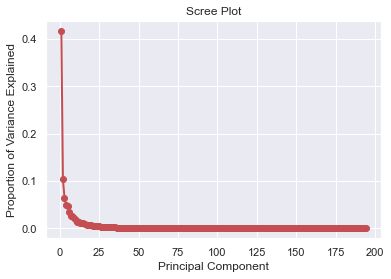

In [49]:
# Let's do this more elegantly with a scree plot

PC_values = np.arange(pca_var.n_components_) + 1
plt.plot(PC_values, pca_var.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [50]:
# Check that 19 PC's explain 90% 
exp_var = pca_var.explained_variance_ratio_

sum = 0
for i in range(0,19):
    sum+=exp_var[i]
    
sum

#Confirmed, YAY!

0.9005697814618338

#### Q7 Answer: 

You can see with both the line plot and the scree plot that 19 PC's are needed to acheive 90% variance.

**8. How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.**


MDS runs for a very long time when running it for the full table so we decided to just run it on a subset of the data and compare the results of MDS and PCA of that subset:

In [61]:
x=filtered_df_no_dip.iloc[:,3:]
subset=x.iloc[:2000,:100]

In [62]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,max_iter=50)
# embedding.fit(subset)
X_transformed = embedding.fit_transform(subset.T)

In [63]:
X_transformed.shape

(100, 2)

In [72]:
len(filtered_df.iloc[:2000,:100].columns)

100

/var/folders/fr/0b8hv04x6_lct76cwxs_zbw80000gn/T/ipykernel_2843/233045729.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


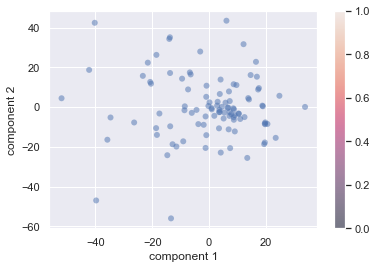

In [81]:
plt.scatter(X_transformed[:,0], X_transformed[:,1],
            edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [82]:
pca_subset = PCA(n_components=2)
pca_subset.fit(subset)

PCA(n_components=2)

In [84]:
# X_pca_sub = pca_subset.transform(subset)
projected_pca = pca_subset.fit_transform(subset.T)
print(projected_pca.shape)

(100, 2)


/var/folders/fr/0b8hv04x6_lct76cwxs_zbw80000gn/T/ipykernel_2843/202940445.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


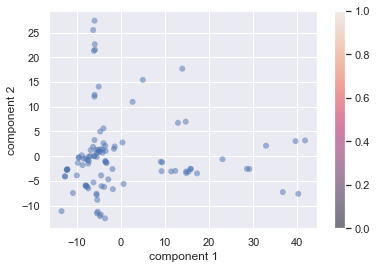

In [86]:
plt.scatter(projected_pca[:, 0], projected_pca[:, 1],
            edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

One way to compare PCA and MDS would be to compare the euclidean distances from the points to each other:

In [87]:
from sklearn.metrics.pairwise import euclidean_distances
euc_mds=euclidean_distances(X_transformed, X_transformed)
euc_pca=euclidean_distances(projected_pca, projected_pca)

In [88]:
max=np.max([np.max(euc_mds),np.max(euc_pca)])

/var/folders/fr/0b8hv04x6_lct76cwxs_zbw80000gn/T/ipykernel_2843/3662967121.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


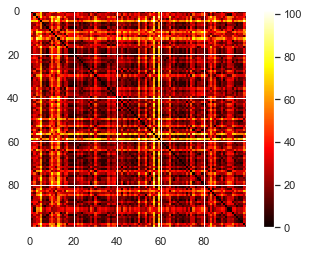

In [89]:
plt.imshow(euc_mds, cmap='hot', interpolation='nearest',vmax=max)
plt.colorbar()

/var/folders/fr/0b8hv04x6_lct76cwxs_zbw80000gn/T/ipykernel_2843/1281527708.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


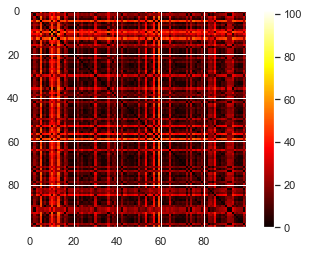

In [90]:
plt.imshow(euc_pca, cmap='hot', interpolation='nearest',vmax=max)
plt.colorbar()

/var/folders/fr/0b8hv04x6_lct76cwxs_zbw80000gn/T/ipykernel_2843/1317480604.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


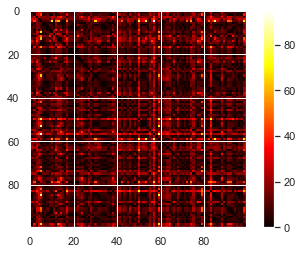

In [91]:
total=np.absolute(euc_mds-euc_pca)
plt.imshow(total, cmap='hot', interpolation='nearest')
plt.colorbar()

In [92]:
np.mean(total)

11.050854232688607

#### Q8 Answer:

From the first plots PCA and MDS might seem like they yield different results but as you can see from the two distance heatmaps, the points in the PCA and in the MDS have very similar distances to each other. In the MDS the points seem to have slightly greater distances between each other but the general patterns can be observed in both PCA and MDS.

The last plot shows the difference between the two heatmaps and as we can see it is very small with a mean of less than 2.5.
This clearly shows that the dimensionality reduction with PCA and MDS are very similar for our data.

**9. Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not? (No plots needed for this question).**

#### Q9 Answer:

NMF is used to decompose a dataset matrix into non-negative sub-matrices. This means that points in the transformed space can be constructed by adding together strictly positive features. This can be useful for interpretability.

We think NMF could be useful for this dataset. We cannot see any clear clustering from our PCA, Due to NMF placing a strong constraint on decomposition, it may better extract reduced dimensions in our dataset. NMF can be useful in finding the experiments most representative of the clusters.